In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os 
import ydata_profiling as yp
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [86]:
df = pd.read_csv('../data/full_gen_data.csv')
df.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,customer_id,...,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255,0
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255,0
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255,0
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238,0
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238,0


In [87]:
df.drop([ 'article', 'customer_id', 'article.1', 'style', 'sizes', 'cost', 'sales', 'regular_price', 'current_price',
         'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col'], axis=1, inplace=True)

In [88]:
df.head()

,country,ratio,retailweek,promo1,promo2,productgroup,category,gender,label
0,Germany,0.663866,2016-03-27,0,0,SHOES,TRAINING,women,0
1,Germany,0.663866,2016-03-27,0,0,SHORTS,TRAINING,women,0
2,Germany,0.663866,2016-03-27,0,0,HARDWARE ACCESSORIES,GOLF,women,0
3,Germany,0.663866,2016-03-27,0,0,SHOES,RUNNING,kids,0
4,Germany,0.663866,2016-03-27,0,0,SHOES,RELAX CASUAL,women,0


In [89]:
df['retailweek'] = pd.to_datetime(df['retailweek'])
df['month'] = df['retailweek'].dt.month

def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return (adjusted_dom - 1) // 7 + 1

df['week_of_month'] = df['retailweek'].apply(week_of_month)

df.drop(['retailweek'], axis=1, inplace=True)

In [90]:
df = df[['country', 'productgroup', 'category', 'gender', 'week_of_month', 'month',  'ratio', 'promo1', 'promo2', 'label']]
for col in df.columns:
    if col not in ['ratio', 'label']:
        df[col] = df[col].astype('category')

In [91]:
df.head()

,country,productgroup,category,gender,week_of_month,month,ratio,promo1,promo2,label
0,Germany,SHOES,TRAINING,women,4,3,0.663866,0,0,0
1,Germany,SHORTS,TRAINING,women,4,3,0.663866,0,0,0
2,Germany,HARDWARE ACCESSORIES,GOLF,women,4,3,0.663866,0,0,0
3,Germany,SHOES,RUNNING,kids,4,3,0.663866,0,0,0
4,Germany,SHOES,RELAX CASUAL,women,4,3,0.663866,0,0,0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   country        100000 non-null  category
 1   productgroup   100000 non-null  category
 2   category       100000 non-null  category
 3   gender         100000 non-null  category
 4   week_of_month  100000 non-null  category
 5   month          100000 non-null  category
 6   ratio          100000 non-null  float64 
 7   promo1         100000 non-null  category
 8   promo2         100000 non-null  category
 9   label          100000 non-null  int64   
dtypes: category(8), float64(1), int64(1)
memory usage: 2.3 MB


In [94]:
df.duplicated().sum()

8272

In [95]:
df.drop_duplicates(inplace=True)

<Axes: xlabel='label', ylabel='ratio'>

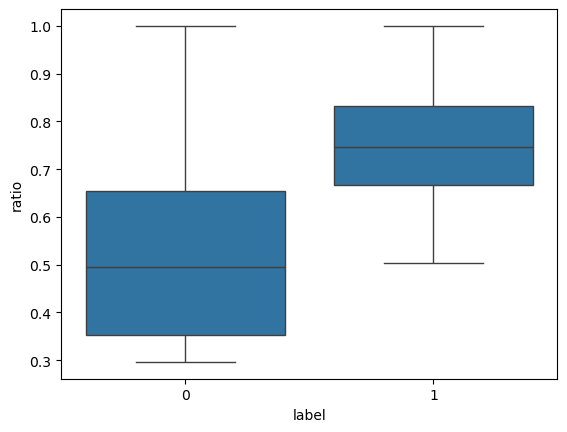

In [96]:
sns.boxplot(data=df, x='label', y='ratio')

In [97]:
profile = yp.ProfileReport(df)
repeat = 0
if not os.path.exists('../reports/fifth_eda_report.html') or repeat:
    prof = yp.ProfileReport(df)
    prof.to_file('../reports/fifth_eda_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [99]:
pd.pivot_table(df, index=['category'], columns=['country'], values=['label'], aggfunc='mean')

label                    
country            Austria    France   Germany
category                                      
FOOTBALL GENERIC  0.146432  0.141844  0.148580
GOLF              0.152275  0.131436  0.151121
INDOOR            0.151468  0.134824  0.136568
RELAX CASUAL      0.161828  0.143725  0.147350
RUNNING           0.148887  0.124831  0.148518
TRAINING          0.145181  0.137722  0.143679

In [165]:
pd.pivot_table(df, index=['category'], columns=['productgroup'], values=['label'], aggfunc='mean')

label                                
productgroup     HARDWARE ACCESSORIES     SHOES    SHORTS SWEATSHIRTS
category                                                             
FOOTBALL GENERIC                  NaN  0.146735       NaN         NaN
GOLF                         0.148358       NaN       NaN         NaN
INDOOR                            NaN  0.141548       NaN         NaN
RELAX CASUAL                      NaN  0.151875       NaN         NaN
RUNNING                      0.146456  0.143184       NaN         NaN
TRAINING                          NaN  0.143418  0.141566    0.144755

In [100]:
pd.pivot_table(df, index=['month'], columns=['week_of_month'], values=['label'], aggfunc='mean').style.highlight_max(axis=1, color='red')

In [101]:
pd.pivot_table(df, index=['month'], columns=['week_of_month'], values=['label'], aggfunc='mean').style.highlight_max(axis=0, color='red')

In [103]:
df.describe(include='category')

,country,productgroup,category,gender,week_of_month,month,promo1,promo2
count,91728,91728,91728,91728,91728,91728,91728,91728
unique,3,4,6,4,5,12,2,2
top,Germany,SHOES,TRAINING,women,4,1,0,0
freq,44560,55027,27540,64212,21918,10997,85642,91248


In [104]:
df.describe().round(2)

,ratio,label
count,91728.00,91728.00
mean,0.55,0.15
std,0.19,0.35
min,0.30,0.00
25%,0.38,0.00
50%,0.54,0.00
75%,0.70,0.00
max,1.00,1.00


In [105]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73382, 9), (18346, 9), (73382,), (18346,))

In [107]:
cat_cols = ['country', 'productgroup', 'category', 'gender', 'week_of_month', 'month', 'promo1', 'promo2']
num_cols = ['ratio']

preprocessor = ColumnTransformer([ ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols),
                                 ], remainder='passthrough')
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_train_prep.shape, X_test_prep.shape

((73382, 31), (18346, 31))

In [108]:
log_reg = LogisticRegression(random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')

lr_cv_results = cross_validate(log_reg, X_train_prep, y_train, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(lr_cv_results['test_accuracy'].mean())
print(lr_cv_results['test_precision'].mean())
print(lr_cv_results['test_recall'].mean())
print(lr_cv_results['test_f1'].mean())
print(lr_cv_results['test_roc_auc'].mean())

0.7427706772711035
0.34211868346083857
0.8324892177283593
0.48493753664943773
0.8491926807994357


In [109]:
log_reg_param_grid = {
    'C': [0.01, 0.1, 10],
    'penalty': ['l1', 'l2']
}

log_reg_grid_search = GridSearchCV(log_reg, log_reg_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
log_reg_grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 10], 'penalty': ['l1', 'l2']},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [111]:
log_reg_grid_search_results = pd.DataFrame(log_reg_grid_search.cv_results_)
log_reg_grid_search_results = log_reg_grid_search_results[['param_C', 'param_penalty', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
log_reg_grid_search_results.round(2)

,param_C,param_penalty,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.01,l1,0.74,0.34,0.83,0.49
1,0.01,l2,0.72,0.33,0.87,0.48
2,0.1,l1,0.74,0.34,0.83,0.49
3,0.1,l2,0.74,0.34,0.84,0.48
4,10,l1,0.74,0.34,0.83,0.48
5,10,l2,0.74,0.34,0.83,0.48


	 Log Reg classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.97      0.70      0.81     62708
           1       0.33      0.86      0.48     10674

    accuracy                           0.73     73382
   macro avg       0.65      0.78      0.65     73382
weighted avg       0.88      0.73      0.77     73382

############################################################
	 Log Reg confusion matrix on training set
############################################################


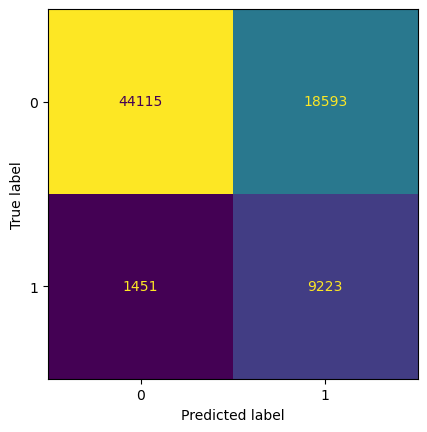

In [112]:
best_log_reg_params = {
    'C': 0.01,
    'penalty': 'l2'}

best_log_reg = LogisticRegression(**best_log_reg_params, random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')
best_log_reg.fit(X_train_prep, y_train)

y_train_pred_lr = best_log_reg.predict(X_train_prep)

print("\t Log Reg classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_lr))
print('#'*60)

print("\t Log Reg confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_lr, colorbar=False)

In [113]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_cv_results = cross_validate(rf, X_train_prep, y_train, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(rf_cv_results['test_accuracy'].mean())
print(rf_cv_results['test_precision'].mean())
print(rf_cv_results['test_recall'].mean())
print(rf_cv_results['test_f1'].mean())
print(rf_cv_results['test_roc_auc'].mean())

0.8051429776683205
0.3104887169094681
0.2781519241279255
0.2934064883135318
0.7915958594701814


In [114]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt'],
    'max_depth': [10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
rf_grid_search.fit(X_train_prep, y_train)


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300]},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [115]:
rf_grid_search_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_grid_search_results = rf_grid_search_results[['param_n_estimators', 'param_max_depth', 'param_max_features',  'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
rf_grid_search_results.round(2)

,param_n_estimators,param_max_depth,param_max_features,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,100,10,None,0.71,0.32,0.89,0.48
1,200,10,None,0.71,0.32,0.90,0.48
2,300,10,None,0.71,0.32,0.90,0.48
3,100,10,sqrt,0.68,0.31,0.94,0.46
4,200,10,sqrt,0.69,0.31,0.94,0.46
5,300,10,sqrt,0.69,0.31,0.94,0.46
6,100,20,None,0.79,0.34,0.46,0.39
7,200,20,None,0.79,0.34,0.46,0.39
8,300,20,None,0.79,0.34,0.46,0.39
9,100,20,sqrt,0.78,0.34,0.52,0.41


	 RF classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     62708
           1       0.31      0.96      0.47     10674

    accuracy                           0.69     73382
   macro avg       0.65      0.80      0.62     73382
weighted avg       0.89      0.69      0.73     73382

############################################################
	 RF confusion matrix on training set
############################################################


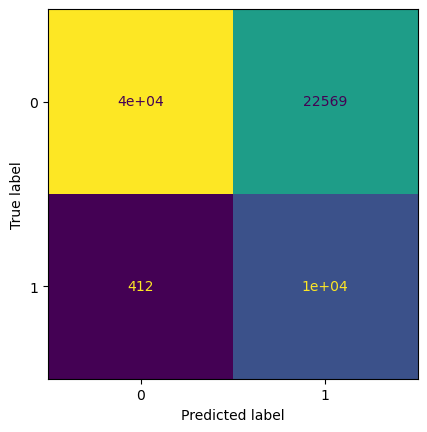

In [116]:
rf_grid_search_best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt'
}

best_rf = RandomForestClassifier(**rf_grid_search_best_params, random_state=42, class_weight='balanced')
best_rf.fit(X_train_prep, y_train)

y_train_pred_rf = best_rf.predict(X_train_prep)

print("\t RF classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_rf))
print('#'*60)

print("\t RF confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf, colorbar=False)

In [117]:
y_train_proba_lr = best_log_reg.predict_proba(X_train_prep)[:, 1]
y_train_proba_rf = best_rf.predict_proba(X_train_prep)[:, 1]

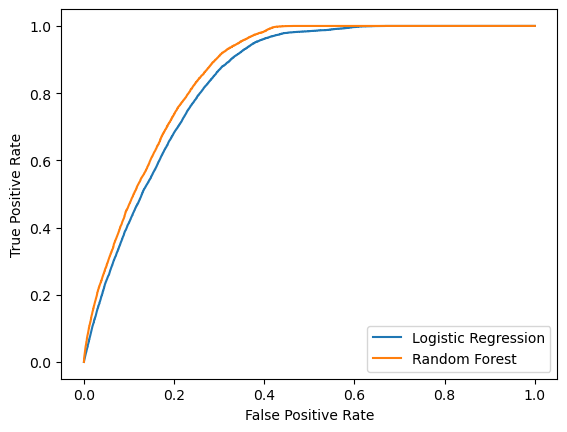

In [118]:
lr_fpr, lr_tpr, _ = roc_curve(y_train, y_train_proba_lr)
rf_fpr, rf_tpr, _ = roc_curve(y_train, y_train_proba_rf)

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

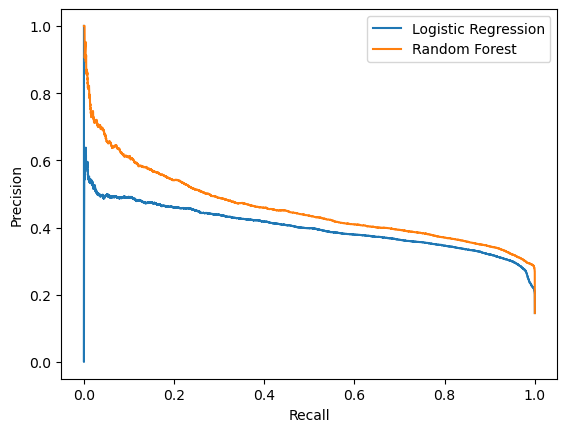

In [119]:
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_train, y_train_proba_lr)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_train, y_train_proba_rf)

plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

	 RF classification report on training set
              precision    recall  f1-score   support

           0       0.96      0.77      0.85     62708
           1       0.37      0.80      0.51     10674

    accuracy                           0.77     73382
   macro avg       0.66      0.78      0.68     73382
weighted avg       0.87      0.77      0.80     73382



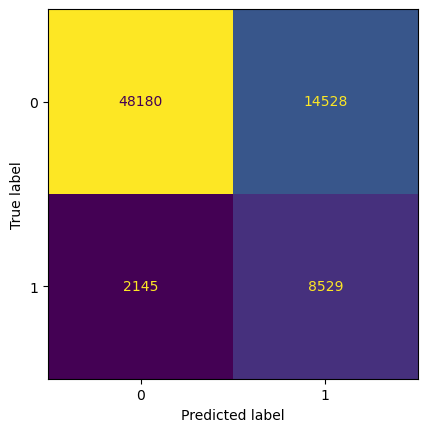

In [138]:
# For Rf: we will increase Probability threshold
prob_threshold = 0.65
rf_train_pred = best_rf.predict_proba(X_train_prep)[:, 1] > prob_threshold

print("\t RF classification report on training set")
print(classification_report(y_train, rf_train_pred))

ConfusionMatrixDisplay.from_predictions(y_train, rf_train_pred, colorbar=False)

In [139]:
from sklearn.pipeline import Pipeline

best_model = Pipeline([
    ('prep', preprocessor),
    ('rf', best_rf)
])


best_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['country', 'productgroup',
                                                   'category', 'gender',
                                                   'week_of_month', 'month',
                                                   'promo1', 'promo2'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])

	 RF classification report on test set
############################################################
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     15677
           1       0.35      0.75      0.48      2669

    accuracy                           0.76     18346
   macro avg       0.65      0.76      0.66     18346
weighted avg       0.86      0.76      0.79     18346

############################################################
	 RF confusion matrix on test set
############################################################


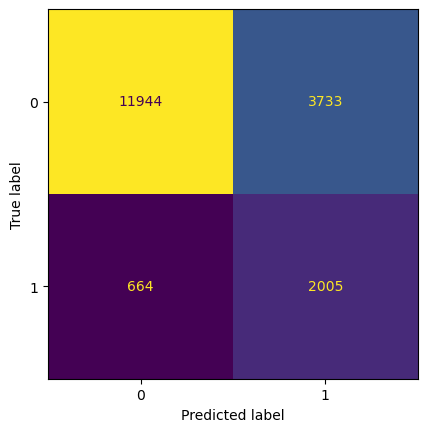

In [140]:
# Predict on test data
prob_threshold = 0.65
y_test_pred = best_model.predict_proba(X_test)[:, 1] > prob_threshold

print("\t RF classification report on test set")
print('#'*60)
print(classification_report(y_test, y_test_pred))
print('#'*60)

print("\t RF confusion matrix on test set")
print('#'*60)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, colorbar=False)

	 RF classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     15677
           1       0.35      0.78      0.48      2669

    accuracy                           0.76     18346
   macro avg       0.65      0.76      0.66     18346
weighted avg       0.86      0.76      0.79     18346

############################################################
	 RF confusion matrix on training set
############################################################


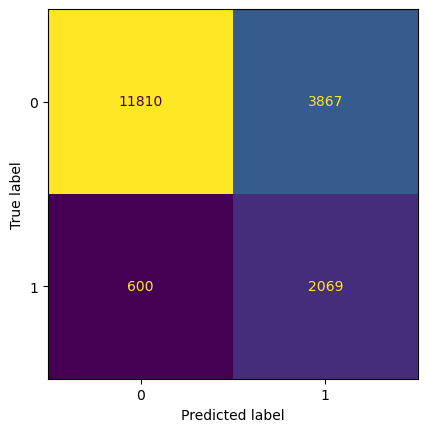

In [163]:
X2 = df.drop(['label', 'week_of_month'], axis=1)
y2 = df['label']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y)
cat_cols = ['country', 'productgroup', 'category', 'gender', 'month', 'promo1', 'promo2']
num_cols = ['ratio']

preprocessor2 = ColumnTransformer([ ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols),
                                 ], remainder='passthrough')

rf2_best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt'
}

best_rf2 = RandomForestClassifier(**rf2_best_params, random_state=42, class_weight='balanced')
best_model2 = Pipeline([
    ('prep', preprocessor2),
    ('rf', best_rf2)
])


best_model2.fit(X2_train, y_train)
y_pred_rf2 = best_model2.predict_proba(X_test)[:, 1] >= prob_threshold

print("\t RF classification report on training set")
print('#'*60)
print(classification_report(y_test, y_pred_rf2))
print('#'*60)

print("\t RF confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf2, colorbar=False)

In [164]:
if not os.path.exists('../models'):
    os.makedirs('../models')

joblib.dump((best_model2, prob_threshold), '../models/rf_model2_with_threshold.joblib')

['../models/rf_model2_with_threshold.joblib']

In [161]:
X2.to_csv('../data/data_less_features_no_label.csv', index=False)

In [167]:
df[df['label'] == 1].sample(10)

,country,productgroup,category,gender,week_of_month,month,ratio,promo1,promo2,label
44701,France,SHORTS,TRAINING,women,5,8,0.661278,0,0,1
53294,France,SHOES,RELAX CASUAL,women,2,8,0.749216,0,0,1
11722,Germany,HARDWARE ACCESSORIES,GOLF,women,3,8,1.000000,0,0,1
74573,Germany,SHOES,RUNNING,kids,1,3,0.742673,0,0,1
89740,France,SHOES,TRAINING,women,3,8,0.688716,0,0,1
94701,Austria,SHORTS,TRAINING,women,2,2,0.861831,0,0,1
65816,France,SHOES,FOOTBALL GENERIC,unisex,2,8,0.550309,0,0,1
98267,Austria,SHOES,INDOOR,women,3,1,0.758204,0,0,1
15422,Austria,HARDWARE ACCESSORIES,GOLF,women,3,7,0.666203,0,0,1
66900,Germany,SHOES,TRAINING,women,5,7,0.870759,1,0,1
